# The data

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# train
batch_size = 32
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        '/data/full/train/',
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')



Found 11430 images belonging to 2 classes.


In [8]:
# validation
validation_generator = train_datagen.flow_from_directory(
        '/data/full/validation/',
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

Found 400 images belonging to 2 classes.


# Hardware

In [9]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8690578794670811364, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5313658880
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3450779186063113296
 physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"]

# The Model

In [1]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224,3))

print (vgg16.input.shape)
print (vgg16.output.shape)

Using TensorFlow backend.


Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 110] Connection timed out

In [11]:
from keras.layers import Conv2D, Reshape, Dense, Activation, BatchNormalization

input = vgg16.input
# vgg16 goes here
fc1 = Conv2D(100, (7,7))(vgg16.output)
fc1_bn = BatchNormalization()(fc1)
fc1_act = Activation('relu')(fc1_bn)

fc2 = Conv2D(2, (1,1))(fc1_act)
fc2_bn = BatchNormalization()(fc2)
fc2_act = Activation('softmax')(fc2_bn)

output = Reshape((2,))(fc2_act)

print (fc1.shape)
print (fc2.shape)
print (output.shape)


(?, 1, 1, 100)
(?, 1, 1, 2)
(?, 2)


In [12]:
from keras.models import Model
from keras.utils import print_summary

model = Model(inputs=input, outputs=output)

print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Training

In [13]:
from keras.optimizers import Adadelta, SGD

optimizer = Adadelta(lr=0.75, rho=0.95, epsilon=None, decay=0.0)

model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Saving train

In [15]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=(3000/32),
        verbose=2,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=10)

Epoch 1/30
 - 68s - loss: 0.6856 - categorical_accuracy: 0.5783 - val_loss: 1.2019 - val_categorical_accuracy: 0.5031
Epoch 2/30
 - 63s - loss: 0.5875 - categorical_accuracy: 0.6761 - val_loss: 6.0934 - val_categorical_accuracy: 0.4934
Epoch 3/30
 - 91s - loss: 0.3944 - categorical_accuracy: 0.8280 - val_loss: 0.8798 - val_categorical_accuracy: 0.5164
Epoch 4/30
 - 122s - loss: 0.3562 - categorical_accuracy: 0.8459 - val_loss: 0.5835 - val_categorical_accuracy: 0.7368
Epoch 5/30
 - 131s - loss: 0.3153 - categorical_accuracy: 0.8787 - val_loss: 0.2809 - val_categorical_accuracy: 0.8844
Epoch 6/30
 - 136s - loss: 0.3077 - categorical_accuracy: 0.8750 - val_loss: 0.5361 - val_categorical_accuracy: 0.6875
Epoch 7/30
 - 138s - loss: 0.2893 - categorical_accuracy: 0.8817 - val_loss: 1.1644 - val_categorical_accuracy: 0.5296
Epoch 8/30
 - 138s - loss: 0.2662 - categorical_accuracy: 0.8937 - val_loss: 0.8867 - val_categorical_accuracy: 0.6217
Epoch 9/30
 - 140s - loss: 0.2559 - categorical_acc

In [20]:
import pickle

experiment_name = 'first_experiment'
base_path = '/data/models/'

model.save(base_path + '/model_' + experiment_name + '.h5')
model.save_weights(base_path + 'weights_' + experiment_name + '.h5')

pkl_file = open(base_path + 'history_' + experiment_name + '.pkl', 'wb')
pickle.dump(history.history, pkl_file)
pkl_file.close()


# Plotting train

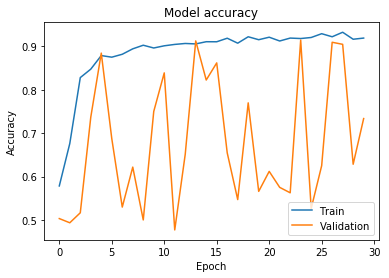

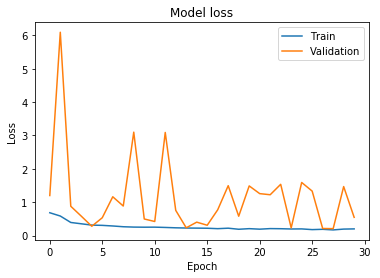

In [23]:
import matplotlib.pyplot as plt

complete_history = history.history

# summarize history for accuracy
plt.plot(complete_history['categorical_accuracy'])
plt.plot(complete_history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(complete_history['loss'])
plt.plot(complete_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Test generator

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# validation
test_batch_size = 25

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        '/data/full/validation/',
        target_size=(224, 224),
        batch_size=test_batch_size,
        shuffle=True,
        class_mode='categorical')

Using TensorFlow backend.


Found 400 images belonging to 2 classes.


In [4]:
from keras.models import load_model

experiment_name = 'first_experiment'
base_path = '/data/models/'

test_model = load_model(base_path + 'model_' + experiment_name + '.h5')

In [8]:
results = test_model.evaluate_generator(test_generator, steps=(400/test_batch_size), verbose=1)
print(test_model.metrics_names)
print(results)

16/16 [==============================] - 3s 195ms/step
['loss', 'categorical_accuracy']
[0.5115197757259011, 0.7350000068545341]
